In [1]:
import os
import glob
import numpy as np
import cv2
import cvlib as cv
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

In [2]:
batch_size = 32
img_height = 224
img_width  = 224
base_lr = 1e-4
epochs  = 50

path = './archive'

In [3]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input)

valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    path+'/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed=93)

valid_generator = valid_datagen.flow_from_directory(
    path+'/valid',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed=93)

Found 7041 images belonging to 2 classes.
Found 3010 images belonging to 2 classes.


In [4]:
img_shape = (img_height, img_width, 3)

base_model = InceptionV3(input_shape=img_shape,
                        include_top=False,
                        weights='imagenet')
base_model.trainable = False

In [5]:
x = base_model.output
x = layers.AveragePooling2D(pool_size=(5, 5), strides=1, padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(2, activation='softmax')(x)
print(x)

Tensor("dense/Softmax:0", shape=(None, 2), dtype=float32)


In [6]:
model = keras.models.Model(inputs=base_model.input, outputs=x)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_lr, decay=base_lr/epochs),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [7]:
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
    filepath='./models/Inception_test.h5',
    monitor='val_loss',
    save_best_only=True)
]

history = model.fit(
          train_generator,
          validation_data=valid_generator,
          epochs=epochs,
          callbacks=callbacks_list
)

Epoch 1/50
221/221 [==============================] - 82s 372ms/step - loss: 0.5489 - accuracy: 0.7624 - val_loss: 0.4383 - val_accuracy: 0.8090
Epoch 2/50
221/221 [==============================] - 87s 394ms/step - loss: 0.4189 - accuracy: 0.8245 - val_loss: 0.5106 - val_accuracy: 0.7970
Epoch 3/50
221/221 [==============================] - 82s 369ms/step - loss: 0.3959 - accuracy: 0.8394 - val_loss: 0.4136 - val_accuracy: 0.8276
Epoch 4/50
221/221 [==============================] - 81s 365ms/step - loss: 0.3989 - accuracy: 0.8391 - val_loss: 0.4189 - val_accuracy: 0.8362
Epoch 5/50
221/221 [==============================] - 81s 365ms/step - loss: 0.3897 - accuracy: 0.8482 - val_loss: 0.3985 - val_accuracy: 0.8359
Epoch 6/50
221/221 [==============================] - 81s 365ms/step - loss: 0.3536 - accuracy: 0.8590 - val_loss: 0.3912 - val_accuracy: 0.8412
Epoch 7/50
221/221 [==============================] - 81s 365ms/step - loss: 0.4030 - accuracy: 0.8451 - val_loss: 0.4928 - val_ac

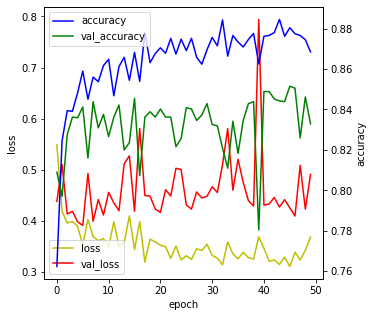

In [8]:
fig, loss_ax = plt.subplots(figsize=(5,5))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val_loss')

acc_ax.plot(history.history['accuracy'], 'b', label='accuracy')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val_accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='lower left')
acc_ax.legend(loc='upper left')
plt.show()